In [1]:
!pip install krippendorff

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import krippendorff

In [91]:
all_results = pd.read_csv("mturk_results/Batch_4938381_batch_results_final.csv").replace("nan", np.nan)
print(all_results.shape)

(1343, 42)


In [92]:
coherence_score_mapping = {
    "是": 10,
    "还行": 7.5,
    "不太好": 2.5,
    "否": 0
}

creative_score_mapping = {
    "有创意感": 10,
    "还行": 5,
    "没有创意": 0
}

like_score_mapping = {
    "我很喜欢这些歌词": 10,
    "我喜欢这些歌词。": 7.5,
    "一般": 5,
    "我不喜欢这些歌词": 2.5,
    "我非常不喜欢这些歌词": 0
}

recognize_score_mapping = {
    "见过": 10,
    "我可能见过": 5,
    "没见过": 0
}

<AxesSubplot: >

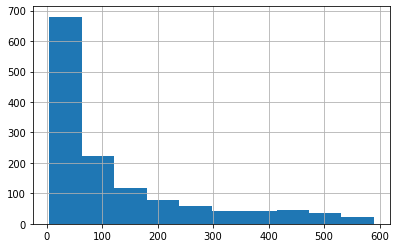

In [143]:
all_results["WorkTimeInSeconds"].hist()

In [144]:
print(all_results.shape)
print(stats.gmean(all_results["WorkTimeInSeconds"]))

(1343, 42)
66.57611864816872


In [145]:
WORK_TIME_THRESHOLD=40

In [146]:
# Banlist based on the responses to writing a summary, typically including copy-pasted text unrelated to the lyrics,
# failing to respond correctly to being able to understand Chinese, spambots, etc.
banlist = [
    "A1IA2JF9P0CRUD",
    "A1XM3URUD94QOV",
    "A3B8KOCZ0MPOP0",
    "A11EZAV2HRYKD5",
    "A1BLDWY2BW9K00",
    "A3C3QGIBQ0P14T",
    "A4V7M88BI7JQ3",
    "A2VUJ3PTQXPDMS",
    "A3980M16RUS4KQ",
    "A1NRY8F9U4AYEK",
    "A2Z4BPD47W08AI",
    "A3OD4F0SA7EBCL",
    "A2P5R40NOOZ4HJ",
    "A17IPBQRGLN7EO",
    "A1VDWRF523BEIU",
    "A29R1LR84VSJU3",
    "A1O51ZAYABZYI5",
    "A2BA1S5LNDMNDQ",
    "A3CVJM1UKKS364",
    "AQ9ISCTDF9B48",
    "AF0FZJIIS6W6Z",
    "AQKNC6HX4QOIT",
    "A20S8LQNA2UHTQ",
    "A252OJSOT5LYQL",
    "A5K2TTBAQD1VT",
    "A3A27SMPYAYN8S",
    "A1ZQVLZDKWIH7V",
    "A3UTSRN8QLKWEA",
    "A11PJ3TQ4LWGWI",
    "A2HJ3P49XKER77",
    "A39L5W9N08RN33",
    "A1VMWZ4X201V7H",
    "A16YRC3B7Y3M20",
    "AFLT0NC11YI7D",
    "AU6SRME5DNC67",
    "AMBLMZYRPW92F",
    "A3SHPBG44GTD5F",
    "A3FD5TA6O848ZW",
    "AK17GMZEUCOF1",
    "A26SWKBPOHR35I",
    "A3HZ96K0U6XSZZ",
    "A1SM32WW2YLFMM",
    "A206WLS4KMBH86",
    "A3FE33S2NMC46Q",
    "A3OFNSL5ZG2N5R",
    "A1VEHETU0E3MPY",
    "A2C556VYMG2BXC"
]

In [147]:
# Compared to the above, these seem to be real people interested in answering questions
# ["A2U1F8KQ6ZTAYI", "A173A97OFDAX9F", "A3MSYMSTHZJI98", "A8IRVPCBEC76V", "A173T1IWICTNER", "A4D99Y82KOLC8", "AR7C4I782M1IS", "A2DNX3DYH3QGQE", "A1W4CUE8A4BRZ4", "ACBK30I7R42NI", "A3B4CQ6VTFJCP6", "A3QXI7YJY3WS4K", "A5K2TTBAQD1VT", "A11QRLR5MXQ2FV", "A1YZHSMNTHT3HD", "A2BF2FUO6F63N7", "A2OYUO1Q8IEPVH", "A2S0VPOB6SIRXZ", "ARW1TCHCLEK1W", "A1N53V41FMCR7Q", "AW14G41VV0BB2", "ASZQYF1HAJMS9", "ARJDD0Z3R65BD", "AUWM7LEMF3H9N"]

In [148]:
def process_mturk_result(df):
    processed_df = pd.DataFrame(df[df["AssignmentStatus"] != "Rejected"])
    processed_df = pd.DataFrame(processed_df[processed_df["WorkTimeInSeconds"] > WORK_TIME_THRESHOLD])
    processed_df = processed_df[processed_df["WorkerId"].apply(lambda a: a not in banlist)]
        
    processed_df["coherence"] = processed_df["Answer.coherence"].fillna(processed_df["Answer.coherence.label"])
    processed_df["creative"] = processed_df["Answer.creative"].fillna(processed_df["Answer.creative.label"])
    processed_df["recognize"] = processed_df["Answer.recognize"].fillna(processed_df["Answer.recognize.label"])
    processed_df["like"] = processed_df["Answer.like"].fillna(processed_df["Answer.like.label"])
    processed_df = processed_df[["coherence", "creative", "recognize", "like", "Input.text", "Input.source", "WorkerId", "WorkTimeInSeconds", "Answer.summary"]].dropna()
    
    processed_df["creative_score"] = processed_df["creative"].apply(lambda a: creative_score_mapping[a])
    processed_df["coherence_score"] = processed_df["coherence"].apply(lambda a: coherence_score_mapping[a])
    processed_df["recognize_score"] = processed_df["recognize"].apply(lambda a: recognize_score_mapping[a])
    processed_df["like_score"] = processed_df["like"].apply(lambda a: like_score_mapping[a])
    
    print(f"Shape: {processed_df.shape}")
    
    return processed_df

In [149]:
def convert_to_krippendorff_input(obs, lookup_dict):
    krip_inp = np.zeros((len(lookup_dict), len(obs)), dtype=int)
    map_dict_keys = sorted(lookup_dict.values())
    map_dict_idx = list(range(0, len(lookup_dict)))
    lookup = dict(zip(map_dict_keys, map_dict_idx))
    
    for i, o in enumerate(obs):
        for d in o:
            krip_inp[lookup[d],i] += 1
            
    return krip_inp.T

In [150]:
all_processed = process_mturk_result(all_results)

Shape: (395, 13)


In [151]:
# Drop responses which didn't follow instructions and didn't attempt to summarize the lyrics, copy pasted parts of the question, etc
# Overlaps somewhat with ban list
all_processed = all_processed[all_processed["Answer.summary"] != "1"]
all_processed = all_processed[all_processed["Answer.summary"] != "否"]
all_processed = all_processed[all_processed["Answer.summary"] != "是"]

all_processed = all_processed[all_processed["Answer.summary"] != "好的"]
all_processed = all_processed[all_processed["Answer.summary"] != "我喜欢这首歌"]
all_processed = all_processed[all_processed["Answer.summary"] != "好歌"]
all_processed = all_processed[all_processed["Answer.summary"] != "它的好听"]
all_processed = all_processed[all_processed["Answer.summary"] != "非常好"]
all_processed = all_processed[all_processed["Answer.summary"] != "我很喜欢"]
all_processed = all_processed[all_processed["Answer.summary"] != "读歌词"]
all_processed = all_processed[all_processed["Answer.summary"] != "我看不到歌词"]
all_processed = all_processed[all_processed["Answer.summary"] != "閱讀歌詞"]
all_processed = all_processed[all_processed["Answer.summary"] != "这是美妙的歌词"]

all_processed = all_processed[all_processed["Answer.summary"] != "good"]
all_processed = all_processed[all_processed["Answer.summary"] != "good."]
all_processed = all_processed[all_processed["Answer.summary"] != "GOOD"]
all_processed = all_processed[all_processed["Answer.summary"] != "NICE"]
all_processed = all_processed[all_processed["Answer.summary"] != "OKAY"]

all_processed = all_processed[all_processed["Answer.summary"] != "{text}"]
all_processed = all_processed[all_processed["Answer.summary"] != "describe these lyrics"]
all_processed = all_processed[~all_processed["Answer.summary"].str.contains("读歌词")]
all_processed = all_processed[~all_processed["Answer.summary"].str.contains("写在这里")]
all_processed = all_processed[~all_processed["Answer.summary"].str.contains("我们要读歌词")]
all_processed = all_processed[~all_processed["Answer.summary"].str.contains("形容这些")]
all_processed = all_processed[~all_processed["Answer.summary"].str.contains("我会读中文")]

Krippendorff is really brutal on this type of skewed data.  We noticed that agreement appears to improve if you filter out quicker responses, but we've decided against using response time directly as a measure of survey response quality.

In [172]:
method = "ordinal"

like_agreement = list(all_processed.groupby("Input.text").aggregate(lambda tdf: tdf.tolist())["like_score"].to_list())
recognize_agreement = list(all_processed.groupby("Input.text").aggregate(lambda tdf: tdf.tolist())["recognize_score"].to_list())
coherence_agreement = list(all_processed.groupby("Input.text").aggregate(lambda tdf: tdf.tolist())["coherence_score"].to_list())
creative_agreement = list(all_processed.groupby("Input.text").aggregate(lambda tdf: tdf.tolist())["creative_score"].to_list())

krip_coherence = convert_to_krippendorff_input(coherence_agreement, coherence_score_mapping)
krip_creativity = convert_to_krippendorff_input(creative_agreement, creative_score_mapping)
krip_recognize = convert_to_krippendorff_input(recognize_agreement, recognize_score_mapping)
krip_like = convert_to_krippendorff_input(like_agreement, like_score_mapping)

co_score = krippendorff.alpha(value_counts=krip_coherence, level_of_measurement=method)
crea_score = krippendorff.alpha(value_counts=krip_creativity, level_of_measurement=method)
recog_score = krippendorff.alpha(value_counts=krip_recognize, level_of_measurement=method)
like_score = krippendorff.alpha(value_counts=krip_like, level_of_measurement=method)

print(co_score)
print(crea_score)
print(recog_score)
print(like_score)

-0.26178317664820283
-0.19730520593728929
-0.27540697785266
-0.2348557107234137


In [168]:
def calc_stdev(agreement_in):
    stds = []
    for a in agreement_in:
        if (len(a) > 1):
            stds.append(np.std(a))

    return(np.mean(stds))

In [171]:
print(calc_stdev(coherence_agreement))
print(calc_stdev(like_agreement))
print(calc_stdev(recognize_agreement))
print(calc_stdev(creative_agreement))

1.290139472401979
1.676581077288311
2.6749175048601375
1.9469269209019002


In [153]:
# Little experiment looking at splitting out individual reviewers
avg_by_worker = all_processed.groupby("WorkerId").mean(numeric_only=True)
def scale_score(df, col_name):
    """Scale the score based on the average value the reviewer selects"""
    df[col_name+"_scaled"] = df.apply(lambda a: a[col_name]-avg_by_worker.loc[a["WorkerId"]][col_name], axis=1)
    return df

for label in ["creative_score", "coherence_score", "like_score", "recognize_score"]:
    all_processed = scale_score(all_processed, label)

mean_scores = all_processed.groupby("Input.source").mean(numeric_only=True)
raws_only = mean_scores[["creative_score","coherence_score","like_score","recognize_score"]]
raws_only.index = [0.80, 0.85, 0.90, 0.95, 0.99, 1.0]
real_point = pd.DataFrame(raws_only.loc[1.00])

In [154]:
raws_only = raws_only.rename(columns={"creative_score": "Creativity", "coherence_score": "Coherence", "like_score": "Affinity", "recognize_score": "Recognize"})

In [155]:
fake_raws = raws_only[0.8:0.99]

C:\Users\Gamer\AppData\Local\Temp\ipykernel_26508\202670222.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(real_point.loc["coherence_score"], "go", color='darkorange')
C:\Users\Gamer\AppData\Local\Temp\ipykernel_26508\202670222.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(real_point.loc["like_score"], "go", color='darkolivegreen')
C:\Users\Gamer\AppData\Local\Temp\ipykernel_26508\202670222.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(real_point.loc["creative_score"], "go", color='royalblue')
C:\Users\Gamer\AppData\Local\Temp\ipykernel_26508\202670222.py:11: UserWarning: color is redundantly defined by the '

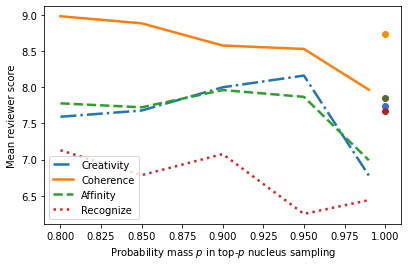

In [156]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.plot(fake_raws["Creativity"].T, linestyle="dashdot", linewidth=2.5)
plt.plot(fake_raws["Coherence"].T, linestyle="solid", linewidth=2.5)
plt.plot(fake_raws["Affinity"].T, linestyle="dashed", linewidth=2.5)
plt.plot(fake_raws["Recognize"].T, linestyle="dotted", linewidth=2.5)
plt.plot(real_point.loc["coherence_score"], "go", color='darkorange')
plt.plot(real_point.loc["like_score"], "go", color='darkolivegreen')
plt.plot(real_point.loc["creative_score"], "go", color='royalblue')
plt.plot(real_point.loc["recognize_score"], "go", color='firebrick')

plt.rcParams["figure.figsize"] = (6.4,4)
plt.xlabel("Probability mass $p$ in top-$p$ nucleus sampling")
plt.ylabel("Mean reviewer score")
plt.legend(raws_only.columns)
plt.show()

In [157]:
#raws_only.plot.line()

In [1394]:
#scalies_only = mean_scores[["creative_score_scaled","coherence_score_scaled","like_score_scaled","recognize_score_scaled"]]
#scalies_only.plot.line()